# ANN for Regression

I retrained 04a-Full-ANN script by using Dataset class that I created for spiliting data into train and test. I also used batch and I observed the model converge much faster than using all data. In this script I only used continuous features for training.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [4]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the target

In [5]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')
    
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [6]:
for cat in cat_cols:
#    df[cat] = df[cat].astype('category')
    
    df[cat] = df[cat].cat.codes.values

In [7]:
df = df[cat_cols+cont_cols+y_col]
df.shape

(120000, 10)

In [28]:
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dt, target, cats=None, IDs=None, size=None, seed=123):
        'Initialization'
        if IDs is None:
            np.random.seed(seed)
            self.ids = list(np.where(np.random.rand(dt.shape[0]) < size)[0])
            print('len of dataset: '+str(len(self.ids)))
        else:
            self.ids = IDs
        
        self.target = torch.from_numpy(dt[target][self.ids].values.astype(np.float32).reshape(-1,1))
        dt = dt.drop(target, axis=1)
        if cats is not None:
            self.cats  = torch.from_numpy(dt[cats].iloc[self.ids].values.astype(np.int64))
            dt = dt.drop(cats, axis=1)
        if dt.shape[0] > 0:
            self.data  = torch.from_numpy(dt.iloc[self.ids].values.astype(np.float32))
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)
    
    def __getitem__(self, index):
        'Generates one sample of data'
#        print(index, self.data[index])

        return self.data[index], self.cats[index], self.target[index]

In [29]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [30]:
# Parameters
params = {'batch_size': 10000,
          'shuffle': False,
          'num_workers': 6}

np.random.seed(123)
size = 0.8
rand = np.random.rand(df.shape[0])
train_ids = list(np.where(rand < size)[0])
test_ids = list(np.where(rand >= size)[0])

print(len(train_ids), len(test_ids))

training_set = Dataset(df, 'fare_amount', cats=cat_cols, IDs=train_ids)
training_generator = data.DataLoader(training_set, **params)

testing_set = Dataset(df, 'fare_amount', cats=cat_cols, IDs=test_ids)
testing_generator = data.DataLoader(training_set, **params)

96115 23885


In [31]:
torch.manual_seed(33)
model = TabularModel(emb_szs, len(cont_cols), 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [32]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
import time
start_time = time.time()

epochs = 100
losses1 = []
losses2 = []

for i in range(epochs):
    i+=1
    
    for continuous, categoricals, target in training_generator:
        y_pred = model(categoricals, continuous)
        loss = torch.sqrt(criterion(y_pred, target))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    with torch.set_grad_enabled(False):
        y_pred = model(training_set.cats, training_set.data)
        loss = torch.sqrt(criterion(y_pred, training_set.target))
        losses1.append(loss)
        
        y_pred = model(testing_set.cats, testing_set.data)
        loss = torch.sqrt(criterion(y_pred, testing_set.target))
        losses2.append(loss)
    
    # a neat trick to save screen space:
    if i%2 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 11.78448391
epoch:   3  loss: 10.81825352
epoch:   5  loss: 10.30144405
epoch:   7  loss: 9.91861153
epoch:   9  loss: 9.51752377
epoch:  11  loss: 9.00436497
epoch:  13  loss: 8.36773682
epoch:  15  loss: 7.57515526
epoch:  17  loss: 6.64361334
epoch:  19  loss: 5.70328808
epoch:  21  loss: 4.85085249
epoch:  23  loss: 4.27040100
epoch:  25  loss: 4.00558949
epoch:  27  loss: 3.94177628
epoch:  29  loss: 3.87570453
epoch:  31  loss: 3.77641296
epoch:  33  loss: 3.81120610
epoch:  35  loss: 3.70913267
epoch:  37  loss: 3.69271564
epoch:  39  loss: 3.66151094
epoch:  41  loss: 3.61323333
epoch:  43  loss: 3.61331630
epoch:  45  loss: 3.58662510
epoch:  47  loss: 3.57461190
epoch:  49  loss: 3.57435584
epoch:  51  loss: 3.51498079
epoch:  53  loss: 3.51675653
epoch:  55  loss: 3.51901412
epoch:  57  loss: 3.50915122
epoch:  59  loss: 3.47476768
epoch:  61  loss: 3.54567552
epoch:  63  loss: 3.45913959
epoch:  65  loss: 3.44045162
epoch:  67  loss: 3.45777059
epoch:  69 

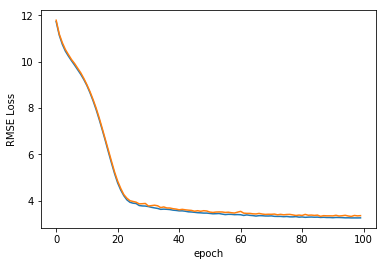

In [34]:
plt.plot(range(epochs), losses1)
plt.plot(range(epochs), losses2)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');